In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
from matplotlib import colors
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import  GreenSampling
from mitsuba import Float, Point2f

In [2]:
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 1

In [3]:
green = GreenSampling.Polynomial
boundary1 = {}
boundary1["m"] = 5

green = GreenSampling.Polynomial
boundary2 = {}
boundary2["m"] = 2

def source(points, params):
    return params["m"] * points[0]


In [5]:
rad = 1
bbox = [[-1.05 * rad, -1.05 * rad], [1.05 * rad, 1.05 * rad]]
resolution_image = [256, 256]
spp_image = 256
epsilon = 1e-3
z_max = 5

dirichlet = [FunctionCoefficient("dirichlet", boundary1, source), FunctionCoefficient("dirichlet", boundary2, source)]
#dirichlet = ConstantCoefficient("dirichlet", 1)
neumann = [ConstantCoefficient("neumann",0), ConstantCoefficient("neumann", 0)]
σ = ConstantCoefficient("screening", 0)
f = ConstantCoefficient("source", 0)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=dirichlet)
data_holder = DataHolder(shape = shape, σ = σ, f=f, default_majorant = 10)

In [6]:
points = create_image_points(bbox, resolution_image, spp_image)
wos_c = WosConstant(data_holder, seed = 21)


In [7]:
wos_v = WosVariable(data_holder, seed = 22, use_accelaration = False, max_z=z_max)
L_c, p = wos_c.solve(points_in = points, conf_numbers=conf_numbers)
image_c, tensor = create_image_from_result(L_c, resolution_image)

In [8]:
L_v, p = wos_v.solve(points_in = points, conf_numbers = conf_numbers)
image_v, tensor = create_image_from_result(L_v, resolution_image)

0 : 16777216 -> 0


Text(0.5, 1.0, 'Variable')

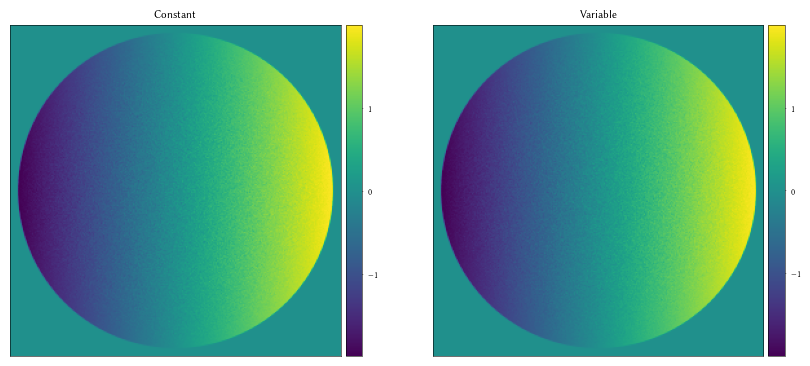

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plot_image(image_c[conf_vis], ax1)
plot_image(image_v[conf_vis], ax2)
ax1.set_title("Constant")
ax2.set_title("Variable")

Mean:
0.0002186519
Variance:
0.0055495487


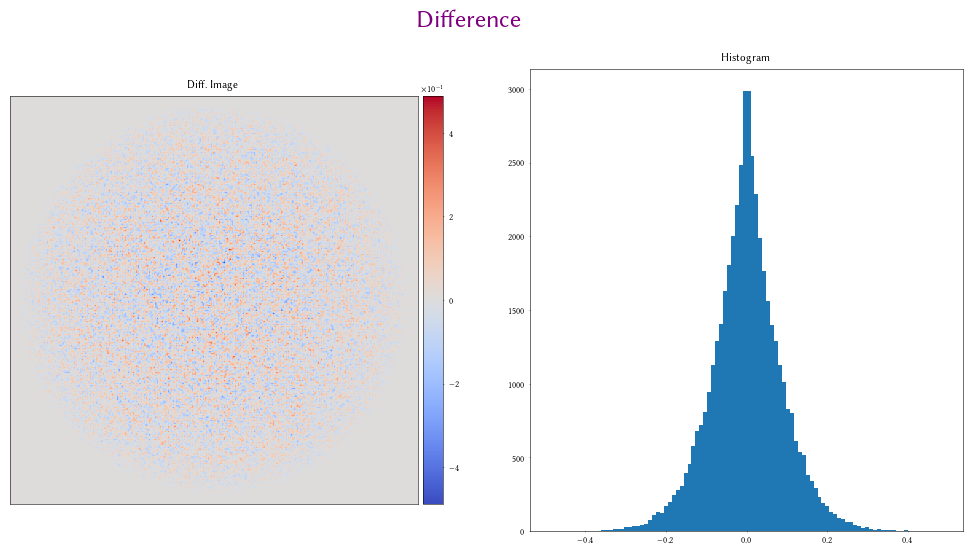

In [10]:
sketch_diff(image_v[conf_vis], image_c[conf_vis])

In [11]:
rad_der = 0.3
res = 128
spp_der = 2 ** 18
fd_step = 5e-3
points = create_circle_points(radius = rad_der, resolution = res, spp = spp_der)
derivative_dir = points / dr.norm(points)
derivative_dir2 =Point2f(-derivative_dir[1], derivative_dir[0])

In [12]:
derL_v, _ = wos_v.solve(points_in = points, derivative_dir = derivative_dir, conf_numbers=conf_numbers)
der_v, _ = create_circle_from_result(derL_v, res)

0 : 33554432 -> 0


In [13]:
derL_c, _ = wos_c.solve(points_in = points, derivative_dir = derivative_dir, conf_numbers=conf_numbers)
der_c, _ = create_circle_from_result(derL_c, res)

Text(0.5, 1.0, 'Radial Derivative Comparison')

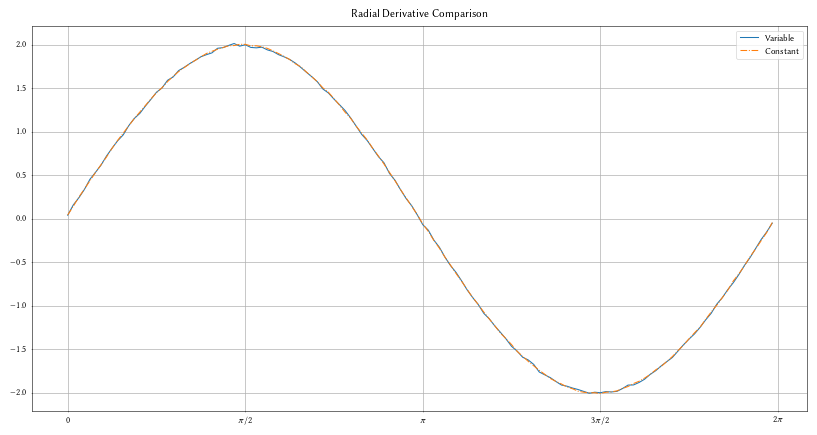

In [14]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, der_v[conf_vis], label = "Variable")
ax.plot(angle, der_c[conf_vis], label = "Constant", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")